In [4]:
%load_ext autoreload
%autoreload 2

## Load dependencies

In [10]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from nnAudio import Spectrogram

import beatbrain
from beatbrain import get_default_config, Config
from beatbrain.utils.visualization import show_heatmap, show_audio, show_spec

## Visualize spectrogram for one audio sample

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Load audio

In [12]:
audio_config = get_default_config().hparams.audio
audio, sr = librosa.load("../data/fma/audio/train/000/000002.mp3", **audio_config)
audio_tensor = torch.tensor(audio, dtype=torch.float32, device=device)
show_audio(audio, rate=sr)

c:\users\krish\miniconda3\envs\ai\lib\site-packages\librosa\core\audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


### Initialize Mel filter bank

In [13]:
spec_config = get_default_config().hparams.spec
print(spec_config)
audio_to_mel = Spectrogram.MelSpectrogram(n_fft=spec_config.n_fft, hop_length=spec_config.hop_length, n_mels=spec_config.n_mels, device=device)

{'flip': True, 'hop_length': 256, 'n_fft': 4096, 'n_frames': 640, 'n_mels': 512, 'top_db': 80, 'truncate': True}
STFT filter created, time used = 0.0180 seconds
Mel filter created, time used = 0.0180 seconds


### Convert audio to mel spectrogram and display

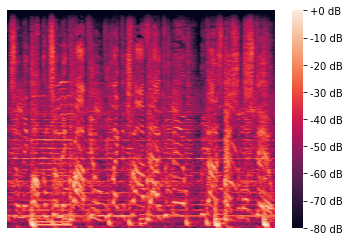

In [14]:
spec_tensor = audio_to_mel(audio_tensor[:(sr * 5) - 1])
spec = spec_tensor[0].cpu().numpy()
show_heatmap(spec)

## Converting Mel Spectrogram to Audio

In [136]:
from pathlib import Path

from nnAudio import Spectrogram
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import pytorch_lightning as pl

from beatbrain import helpers, datasets, utils
from beatbrain import Config


class SpectrogramToAudio(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        self.n_fft = self.hparams.spec.n_fft
        self.hop_length = self.hparams.spec.hop_length
        self.n_mels = self.hparams.spec.n_mels

        self.mel = Spectrogram.MelSpectrogram(n_fft=self.n_fft, hop_length=self.hop_length, n_mels=self.n_mels)
        self.stft_mag = Spectrogram.STFT(n_fft=self.n_fft, hop_length=self.hop_length, output_format="Magnitude")
        self.stft_phase = Spectrogram.STFT(n_fft=self.n_fft, hop_length=self.hop_length, output_format="Phase")
        self.stft_complex = Spectrogram.STFT(n_fft=self.n_fft, hop_length=self.hop_length, output_format="Complex")

    def forward(self, x):
        return x

    def loss_fn(audio_pred, audio_target):
        eps = 1e-10
        stft_pred = self.stft_mag(audio_pred)
        stft_target = self.stft_mag(audio_target)
        spectral_convergence = torch.norm(stft_target - stft_pred) / torch.norm(stft_target)
        l1_log_loss = F.l1_loss(torch.log(stft_pred + eps), torch.log(stft_target + eps))
        
#         stft_phase_pred = self.stft_phase(audio_pred)
#         stft_phase_target = self.stft_phase(audio_target)
#         instantaneous_frequency_loss = F.l1_loss()
        
        stft_complex_pred = self.stft_complex(audio_pred)
        stft_complex_target = self.stft_complex(audio_target)
        stft_real_pred, stft_imag_pred = stft_complex_pred[..., 0], stft_complex_pred[..., 1]
        stft_real_target, stft_imag_target = stft_complex_target[..., 0], stft_complex_target[..., 1]
        phase_loss = (stft_target * stft_pred) - (stft_real_target * stft_real_pred) - (stft_imag_target * stft_imag_pred)
        phase_loss = torch.norm(phase_loss, p=1)

        loss = spectral_convergence + l1_log_loss
        return loss

    def training_step(self, batch, batch_idx):
        audio = batch
        mel = self.mel(audio)
        audio_pred = self.forward(mel)
        loss = self.loss_fn(audio_pred, audio)
        return {"loss": sc_loss}

    def validation_step(self, batch, batch_idx):
        audio = batch
        mel = self.mel(audio)
        audio_pred = self.forward(mel)
        loss = self.loss_fn(audio_pred, audio)
        return {"val_loss": sc_loss}

    def test_step(self, batch, batch_idx):
        audio = batch
        mel = self.mel(audio)
        audio_pred = self.forward(mel)
        loss = self.loss_fn(audio_pred, audio)
        return {"test_loss": sc_loss}

    def validation_epoch_end(self, outputs):
        print(outputs)
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        tensorboard_logs = {"loss/val_loss": avg_loss}
        return {"val_loss": avg_loss, "log": tensorboard_logs}

    def prepare_data(self):
        if self.hparams.data.train_dir:
            self.train_dataset = datasets.AudioClipDataset(self.hparams.data.train_dir)
        if self.hparams.data.val_dir:
            self.val_dataset = datasets.AudioClipDataset(self.hparams.data.val_dir)
        if self.hparams.data.test_dir:
            self.test_dataset = datasets.AudioClipDataset(self.hparams.data.test_dir)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            **self.hparams.data.train_options
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            **self.hparams.data.val_options
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            **self.hparams.data.test_options
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.2)
        return [optimizer], [scheduler]


MODEL_CONFIG = Config({
    "data": {
        "train_dir": "../data/fma/audio/test",  # TODO: SET THIS TO TRAIN DIRECTORY !!!!!!!!!!
        "val_dir": "../data/fma/audio/val",
        "test_dir": "../data/fma/audio/test",
        "train_options": {"batch_size": 1, "shuffle": True},
        "val_options": {"batch_size": 1},
        "test_options": {"batch_size": 1},
    },
    "spec":{
        "n_fft": 4096,
        "hop_length": 256,
        "n_mels": 512,
    },
    "learning_rate": 1e-5,
})
TRAINER_CONFIG = Config({
    "gpus": [0],
    "progress_bar_refresh_rate": 1,
    "max_epochs": 100,
    "loggers": pl.loggers.TestTubeLogger(save_dir="experiments/", name="mel2stft")
})

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE, pin_memory=True, num_workers=1)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE, pin_memory=True, num_workers=1)

model = SpectrogramConverter(MODEL_CONFIG)
trainer = helpers.train.get_trainer(**TRAINER_CONFIG)
trainer.fit(model)

STFT filter created, time used = 0.0170 seconds
Mel filter created, time used = 0.0170 seconds


INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


STFT kernels created, time used = 0.2669 seconds
Found 12516.0 seconds of audio
Found 12712.0 seconds of audio


INFO:lightning:
  | Name          | Type           | Params
---------------------------------------------
0 | audio_to_mel  | MelSpectrogram | 17 M  
1 | audio_to_stft | STFT           | 16 M  


Found 12516.0 seconds of audio


RuntimeError: The size of tensor a (2049) must match the size of tensor b (512) at non-singleton dimension 1